# QRT ENS Challenge Data 2023 - Benchmark

Ce notebook détaille la construction du benchmark de ce challenge - il peut également être utile aux participants pour se lancer dans la compétition. 

## Librairies

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Chargement des données

- `X_train` et `X_test` ont  $10$ colonnes qui représentent les même variables explicatives mais sur des périodes de temps différentes il y a au plus $10 604$ lignes. 

- `X_train` et `y_train` partagent la même colonne `DELIVERY_START` - chaque ligne a un DELIVERY_START unique associéz à une date et heure de livraison de l'électricité
. 

- La variable cible `spot_id_delta` de `y_train` correspond à l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

- **On notera que certaines colonnes ont des valeurs manquantes**.


In [2]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:
X = pd.read_csv('../raw_data/X_train_Wwou3IE.csv')
y = pd.read_csv('../raw_data/y_train_jJtXgMX.csv')
X_rendu = pd.read_csv('../raw_data/X_test_GgyECq8.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

On manipule les données pour enlever les NaN qui ne nous intéressent pas: 

In [3]:
X_train_kept = X_train.dropna(subset=['coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std'])
X_rendu_kept = X_train.dropna(subset=['coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std'])

marked_train = pd.concat([X_train, X_train_kept]).drop_duplicates(keep=False)['DELIVERY_START']
marked_rendu = pd.concat([X_rendu, X_rendu_kept]).drop_duplicates(keep=False)['DELIVERY_START']

X_train = X_train[~X_train['DELIVERY_START'].isin(marked_train)]
y_train = y_train[~y_train['DELIVERY_START'].isin(marked_train)]
X_rendu = X_rendu[~X_rendu['DELIVERY_START'].isin(marked_train)]

In [4]:
X_train.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
4516,2022-07-15 06:00:00+02:00,NaN,2226.0,11140.0,27995.0,2779.0,260.0,50.888446,4.977892,NaN
452,2022-01-19 22:00:00+01:00,70957.0,3386.0,11487.0,49821.0,4783.0,0.0,262.145591,0.000000,NaN
4136,2022-06-29 10:00:00+02:00,50921.0,2226.0,10555.0,28620.0,975.0,6901.0,29.768661,19.272470,NaN
5440,2022-08-22 18:00:00+02:00,46075.0,2226.0,11060.0,26320.0,1919.0,2645.0,141.690169,56.861925,NaN
9162,2023-01-27 20:00:00+01:00,72628.0,3386.0,11945.0,44655.0,6839.0,0.0,363.769772,0.000000,199.06


In [5]:
X_train.describe()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,6519.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,1279.000000
mean,53922.938027,2828.026262,11468.501015,35486.366455,4549.369297,1906.215514,126.730776,25.380678,140.828389
std,11294.635350,491.901064,483.773296,7616.369208,3346.152787,2694.408002,129.816870,44.016714,34.294975
min,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000
25%,45548.000000,2226.000000,11140.000000,29075.000000,2068.500000,0.000000,47.162420,0.000000,120.365000
50%,52084.000000,2806.000000,11487.000000,32540.000000,3364.000000,152.000000,87.456376,3.531372,140.540000
75%,62201.000000,3386.000000,11945.000000,43180.000000,6039.500000,3468.000000,157.424757,35.399240,162.105000
max,85145.000000,3386.000000,11963.000000,50122.000000,15066.000000,10127.000000,1564.336345,745.261316,254.190000


In [6]:
y_train.head()

,DELIVERY_START,spot_id_delta
4516,2022-07-15 06:00:00+02:00,20.659531
452,2022-01-19 22:00:00+01:00,1.461511
4136,2022-06-29 10:00:00+02:00,11.289694
5440,2022-08-22 18:00:00+02:00,25.537520
9162,2023-01-27 20:00:00+01:00,-7.382322


In [7]:
y_train.describe()

,spot_id_delta
count,7387.000000
mean,0.296400
std,39.281045
min,-1567.353547
25%,-12.032543
50%,-0.234599
75%,11.731071
max,415.819924


In [8]:
X_test.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
1974,2022-03-25 23:00:00+01:00,52535.0,3386.0,11952.0,31705.0,6856.0,0.0,358.609320,0.000000,NaN
2086,2022-04-02 00:00:00+02:00,59705.0,2806.0,11567.0,31380.0,10255.0,0.0,74.807837,0.000000,NaN
1361,2022-02-28 10:00:00+01:00,70804.0,3386.0,11952.0,43290.0,2124.0,5684.0,15.866374,27.841991,NaN
2216,2022-04-07 10:00:00+02:00,61938.0,2226.0,11567.0,32275.0,13554.0,2510.0,26.566232,37.130929,NaN
8812,2023-01-13 06:00:00+01:00,55721.0,3386.0,11945.0,46265.0,12888.0,0.0,59.904308,0.000000,78.88


# Data analysis

Représentation graphique des données de test de notre modèle :

## 1) Histogramme des données d'apprentissage

array([[<AxesSubplot:title={'center':'load_forecast'}>,
        <AxesSubplot:title={'center':'coal_power_available'}>,
        <AxesSubplot:title={'center':'gas_power_available'}>],
       [<AxesSubplot:title={'center':'nucelear_power_available'}>,
        <AxesSubplot:title={'center':'wind_power_forecasts_average'}>,
        <AxesSubplot:title={'center':'solar_power_forecasts_average'}>],
       [<AxesSubplot:title={'center':'wind_power_forecasts_std'}>,
        <AxesSubplot:title={'center':'solar_power_forecasts_std'}>,
        <AxesSubplot:title={'center':'predicted_spot_price'}>]],
      dtype=object)

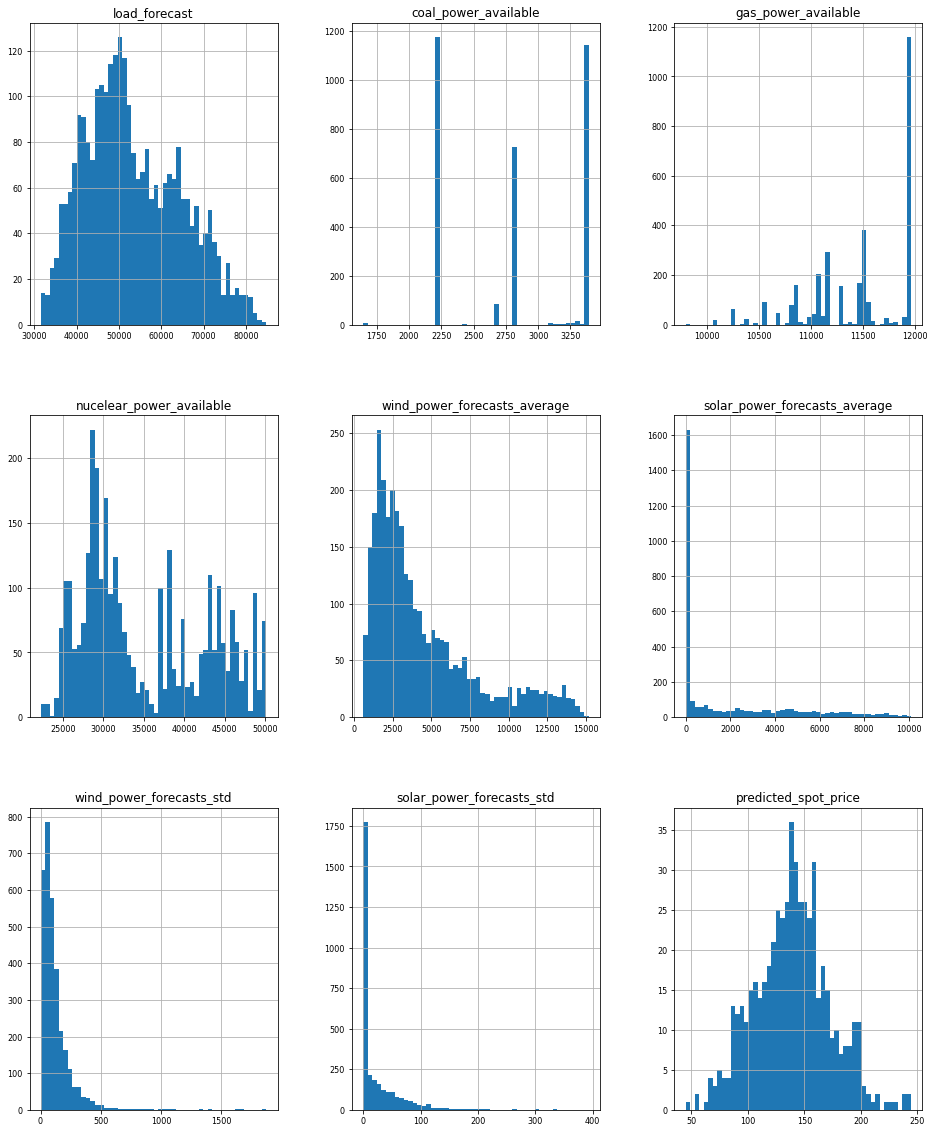

In [9]:
X_test.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

## 2) Répartition des *spot_id_delta* dans *y_train*

C:\Users\matte\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='spot_id_delta', ylabel='Density'>

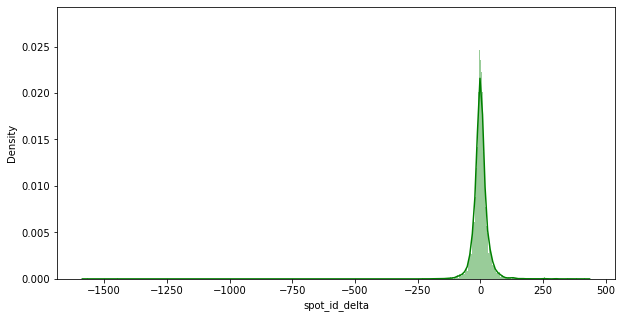

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(y_train['spot_id_delta'], color='g', bins=1000, hist_kws={'alpha': 0.4})

## 3) Corrélation générale entre les paramètres du modèle :

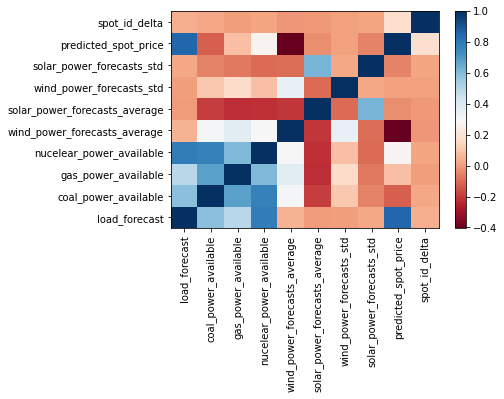

In [11]:
df = pd.merge(X_train, y_train, on='DELIVERY_START', how='inner')
tab=df.corr()
fig, ax = plt.subplots()
im = ax.pcolor(tab, cmap='RdBu')
row_labels = tab.columns
col_labels = tab.index
ax.set_xticks(np.arange(tab.shape[1])+0.5, minor= False)
ax.set_yticks(np.arange(tab.shape[0])+0.5, minor= False)
ax.set_xticklabels(row_labels, minor = False)
ax.set_yticklabels(col_labels, minor = False)
plt.xticks(rotation=90)
fig.colorbar(im)
plt.show()

# Data cleaning

On s'intéresse ici à la présence de nombreuses valeurs NaN. Ces valeurs représentent un vrai manque pour l'entraînement de notre modèle car elles sont majoritairement situées sur les données très corrélées avec le *spot_id_delta*.

## 1) Valeurs aberrantes dans *y_train*

Comme vu lors de la partie Data Analysis, certaines des valeurs de *y_train* (3) ont des valeurs très éloignées des autres. On s'occupe donc ici de retirer ces valeurs qui ne semblent pas cohérentes pour notre modèle :

In [12]:
threshold = 600

eliminated_starts = y_train[abs(y_train['spot_id_delta']) - threshold >= 0].DELIVERY_START

y_train = y_train[~y_train['DELIVERY_START'].isin(eliminated_starts)] # on ne sélectionne que les valeurs qui ne correspondent pas aux dates enlevées
X_train = X_train[~X_train['DELIVERY_START'].isin(eliminated_starts)] # de même ici pour être cohérent sur le nombre de lignes

print(len(y_train))
print(len(X_train))

7385
7385


In [13]:
eliminated_starts.size

2

## 2) Prédiction de *load_forecast*

Il y a environ 1500 données manquantes, que l'on va prédire à l'aide d'un modèle de régression Ridge:

<AxesSubplot:>

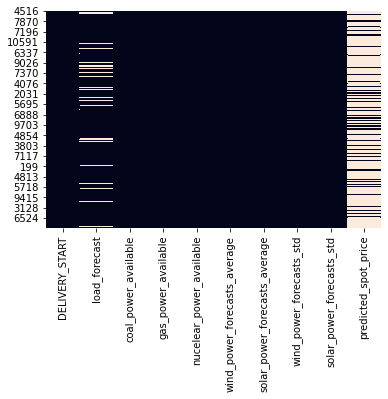

In [14]:
sns.heatmap(X_train.isna(),cbar=False)

In [15]:
predicted_spot_price_train = X_train['predicted_spot_price']
predicted_spot_price_rendu = X_rendu['predicted_spot_price']

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

y_load = X_train.dropna(subset=['load_forecast'])['load_forecast']
X_load = X_train.dropna(subset=['load_forecast'])
X_load = X_load.loc[:, X_load.columns != 'predicted_spot_price']
X_load = X_load.loc[:, X_load.columns != 'load_forecast']

X_train_load, X_test_load, y_train_load, y_test_load = train_test_split(X_load, y_load, test_size=0.3)

clf = LinearRegression()
clf.fit(X_train_load.set_index('DELIVERY_START'), y_train_load)
print('linear regression score: ', clf.score(X_test_load.set_index('DELIVERY_START'), y_test_load))

clf = GradientBoostingRegressor()
clf.fit(X_train_load.set_index('DELIVERY_START'), y_train_load)
print('gradient boosting regression score: ', clf.score(X_test_load.set_index('DELIVERY_START'), y_test_load))

clf = RandomForestRegressor()
clf.fit(X_train_load.set_index('DELIVERY_START'), y_train_load)
print('random forest regression score: ', clf.score(X_test_load.set_index('DELIVERY_START'), y_test_load))

linear regression score:  0.6634290739985632
gradient boosting regression score:  0.7854499329545064
random forest regression score:  0.8815121453552278



On choisit donc ici la régression ayant le meilleur score : Random Forest. On peut maintenant prédire les valeurs manquantes pour le *load_forecast* :

In [17]:
X_predict_load = X_train[X_train['load_forecast'].isna()]
predicted_spot_price1 = X_predict_load['predicted_spot_price']
load_forecast1 = X_predict_load['load_forecast']
X_predict_load = X_predict_load.loc[:, ~(X_predict_load.columns.isin(['predicted_spot_price', 'load_forecast']))]

X_predict_load_rendu = X_rendu[X_rendu['load_forecast'].isna()]
print(X_rendu)
predicted_spot_price2 = X_predict_load_rendu['predicted_spot_price']
load_forecast2 = X_predict_load_rendu['load_forecast']
X_predict_load_rendu = X_predict_load_rendu.loc[:, ~(X_predict_load_rendu.columns.isin(['predicted_spot_price', 'load_forecast']))]

X_predict_load.insert(1, 'load_forecast', clf.predict(X_predict_load.set_index('DELIVERY_START')))
X_predict_load.insert(9, 'predicted_spot_price', predicted_spot_price1)

X_predict_load_rendu.insert(1, 'load_forecast', clf.predict(X_predict_load_rendu.set_index('DELIVERY_START')))
X_predict_load_rendu.insert(9, 'predicted_spot_price', predicted_spot_price2)

                 DELIVERY_START  load_forecast  coal_power_available  \
0     2023-04-02 00:00:00+02:00        45814.0                3386.0   
1     2023-04-02 01:00:00+02:00        44084.0                3386.0   
2     2023-04-02 02:00:00+02:00        43281.0                3386.0   
3     2023-04-02 03:00:00+02:00        40825.0                3386.0   
4     2023-04-02 04:00:00+02:00        39181.0                3386.0   
...                         ...            ...                   ...   
4937  2023-10-24 19:00:00+02:00        49686.0                2226.0   
4938  2023-10-24 20:00:00+02:00        53397.0                2226.0   
4939  2023-10-24 21:00:00+02:00        50586.0                2226.0   
4940  2023-10-24 22:00:00+02:00        46777.0                2226.0   
4941  2023-10-24 23:00:00+02:00        46380.0                2226.0   

      gas_power_available  nucelear_power_available  \
0                 10902.0                   36705.0   
1                 10902.0

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required.

In [18]:
X_train = pd.concat([X_train[~X_train['load_forecast'].isna()], X_predict_load])
X_rendu = pd.concat([X_rendu[~X_rendu['load_forecast'].isna()], X_predict_load_rendu])
X_train.head()

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
452,2022-01-19 22:00:00+01:00,70957.0,3386.0,11487.0,49821.0,4783.0,0.0,262.145591,0.000000,NaN
4136,2022-06-29 10:00:00+02:00,50921.0,2226.0,10555.0,28620.0,975.0,6901.0,29.768661,19.272470,NaN
5440,2022-08-22 18:00:00+02:00,46075.0,2226.0,11060.0,26320.0,1919.0,2645.0,141.690169,56.861925,NaN
9162,2023-01-27 20:00:00+01:00,72628.0,3386.0,11945.0,44655.0,6839.0,0.0,363.769772,0.000000,199.06
153,2022-01-07 11:00:00+01:00,78583.0,3386.0,11487.0,47728.0,8171.0,2559.0,100.930265,12.044037,NaN


In [19]:
X_train['predicted_spot_price'] = predicted_spot_price_train
X_rendu['predicted_spot_price'] = predicted_spot_price_rendu
X_train['predicted_spot_price'].describe()

count    1279.000000
mean      140.828389
std        34.294975
min        42.420000
25%       120.365000
50%       140.540000
75%       162.105000
max       254.190000
Name: predicted_spot_price, dtype: float64

## 3) Prédiction de *predicted_spot_price*

Maintenant, les valeurs pour de *load_forecast* NaN ont été remplacées. De part la forte corrélation en *predicted_spot_price* en *load_forecast*, et comme on dispose de toutes les valeurs de *load_forecast*, on peut maintenant créer un modèle capable de nous prédire les valeurs de *predicted_spot_price* manquantes:

<AxesSubplot:>

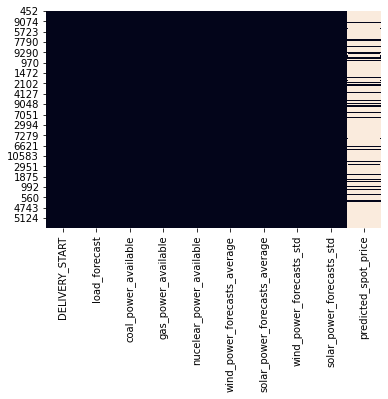

In [20]:
sns.heatmap(X_train.isna(),cbar=False) # vérification qu'il n'y a plus de valeur manquante dans load_forecast

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint

delivery_starts = X_train['DELIVERY_START']

y_spot = X_train.dropna(subset=['predicted_spot_price'])['predicted_spot_price']
X_spot = X_train.dropna(subset=['predicted_spot_price'])
X_spot = X_spot.loc[:, X_spot.columns != 'predicted_spot_price']
X_spot = X_spot.set_index('DELIVERY_START')

print('nombre de valeurs non NaN: ', len(y_spot))

X_train_spot, X_test_spot, y_train_spot, y_test_spot = train_test_split(X_spot, y_spot, test_size=0.25)

clf = LinearRegression()
clf.fit(X_train_spot, y_train_spot)
print('linear regression score: ', clf.score(X_test_spot, y_test_spot))

clf = RandomForestRegressor()
clf.fit(X_train_spot, y_train_spot)
print('random forest regression score: ', clf.score(X_test_spot, y_test_spot))

clf = GradientBoostingRegressor()
clf.fit(X_train_spot, y_train_spot)
print('gradient boosting regression score: ', clf.score(X_test_spot, y_test_spot))

nombre de valeurs non NaN:  1279
linear regression score:  0.737953421536983
random forest regression score:  0.7990867718393576
gradient boosting regression score:  0.810684581320599


In [22]:
X_predict_spot = X_train[X_train['predicted_spot_price'].isna()]
X_predict_spot = X_predict_spot.loc[:, X_predict_spot.columns != 'predicted_spot_price']
X_predict_spot = X_predict_spot.set_index('DELIVERY_START')

X_predict_rendu = X_rendu[X_rendu['predicted_spot_price'].isna()]
X_predict_rendu = X_predict_rendu.loc[:, X_predict_rendu.columns != 'predicted_spot_price']
X_predict_rendu = X_predict_rendu.set_index('DELIVERY_START')

X_predict_spot.insert(8, 'predicted_spot_price', clf.predict(X_predict_spot))
X_predict_rendu.insert(8, 'predicted_spot_price', clf.predict(X_predict_rendu))
X_predict_spot.head()

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
DELIVERY_START,,,,,,,,,
2022-01-19 22:00:00+01:00,70957.0,3386.0,11487.0,49821.0,4783.0,0.0,262.145591,0.000000,176.270541
2022-06-29 10:00:00+02:00,50921.0,2226.0,10555.0,28620.0,975.0,6901.0,29.768661,19.272470,114.634861
2022-08-22 18:00:00+02:00,46075.0,2226.0,11060.0,26320.0,1919.0,2645.0,141.690169,56.861925,103.406219
2022-01-07 11:00:00+01:00,78583.0,3386.0,11487.0,47728.0,8171.0,2559.0,100.930265,12.044037,195.736762
2022-04-25 19:00:00+02:00,48511.0,2806.0,11140.0,30420.0,2473.0,1178.0,191.893942,10.167603,112.560855


<AxesSubplot:>

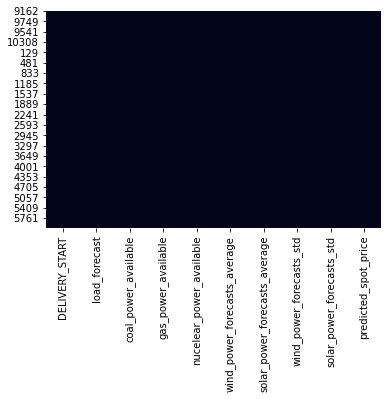

In [23]:
X_train = pd.concat([X_train[~X_train['predicted_spot_price'].isna()], X_predict_spot.reset_index('DELIVERY_START')])
X_rendu = pd.concat([X_rendu[~X_rendu['predicted_spot_price'].isna()], X_predict_rendu.reset_index('DELIVERY_START')])
sns.heatmap(X_train.isna(),cbar=False)

<AxesSubplot:>

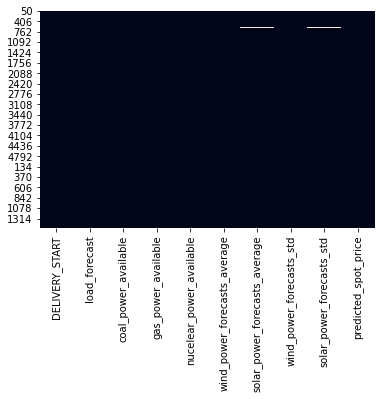

In [24]:
sns.heatmap(X_rendu.isna(),cbar=False)

In [25]:
X_train.to_csv('../data/X_train.csv')
y_train.to_csv('../data/y_')
X_rendu.to_csv('../data/X_test.csv')

On remarque bien que le database est maintenant dépourvu de valeurs NaN !

## Astuces et idées d'amélioration

- Réféchir à la modélation des différents facteurs qui font bouger les prix de l'électricité dans chaque pays pourra être utile. 

- Le jeu de données est relativement petit - c'est un "small data challenge" - alors attention à ne pas surapprendre les paramètres de vos modèles ! Il sera certainement utile de mettre en place de bonnes pratiques de validation croisée.


In [ ]:
lm=LinearRegression()
Z = X_train_clean
lm.fit(Z, Y_train['spot_id_delta'])
Y_hat = lm.predict(X_train_clean)
sns.residplot(Z['load_forecast'], Y_train['spot_id_delta'])

In [ ]:
Input = [('Scale',StandardScaler()),('polynomial',PolynomialFeatures(degree=2)),('model',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(X_train_clean,Y_train['spot_id_delta'])
Y_hat=pipe.predict(X_train_clean)

On voit quand on trace les résidus de la regression linéaire entre le load_forecast en France et la différence, une distribution équiprobable partout ce qui laisse penser que la regression linéaire est correcte


In [ ]:
RSQ_test= []
lr=LinearRegression()
X_test_clean = X_test.drop(['DELIVERY_START'], axis=1).fillna(0)
Y_test_clean = Y_train.drop(['DELIVERY_START'], axis=1).fillna(0)
order = [1,2,3,4,5]
for n in order :
    pr = PolynomialFeatures(degree=n)
    x_train_pr=pr.fit_transform(X_train_clean[['load_forecast']])
    x_test_pr=pr.fit_transform(X_test_clean[['load_forecast']])
    lr.fit(x_train_pr,Y_train_clean)
    RSQ_test.append(lr.score(x_test_pr,Y_test_clean))

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

RidgeModel = Ridge(alpha=0.1)
RidgeModel.fit(X_train_clean,Y_train_clean)
Yhat=RidgeModel.predict(X_train_clean)

parameters = [{'alpha': [0.001,2,10,100,1000,10000,100000,1000000000]}]
RR=Ridge()
Grid1=GridSearchCV(RR,parameters,cv=5)
Grid1.fit(X_train_clean,Y_train_clean)
Grid1.best_estimator_
scores=Grid1.cv_results_


for param, mean_val in zip(scores['params'],scores['mean_test_score']):
    print(param, "R^2 on test data:", mean_val)
    
